In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as t
import torch.nn as nn
import torch.optim as optim

# used in Cambridge Spark tutorial
from sklearn.metrics.pairwise import pairwise_distances

In [20]:
data = pd.read_csv("data/data.txt", sep="\t", header=None,
                   names=["user", "movie", "rating"])
movies = pd.read_csv("data/movies.txt", sep="\t", header=None, index_col=0,
                     names=["movie","title","unknown","action","adventure","animation",
                            "childrens", "comedy","crime","documentary","drama",
                            "fantasy", "filmnoir", "horror","musical","mystery",
                            "romance","scifi","thriller","war","western"]
                    )

In [25]:
# Test and train sets are formatted the same way as data
train = pd.read_csv("data/train.txt", sep="\t", header=None,
                   names=["user", "movie", "rating"])
test = pd.read_csv("data/test.txt", sep="\t", header=None,
                   names=["user", "movie", "rating"])

In [26]:
data

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [22]:
data["rating"]

0        3
1        3
2        1
3        2
4        1
        ..
99995    3
99996    5
99997    1
99998    2
99999    3
Name: rating, Length: 100000, dtype: int64

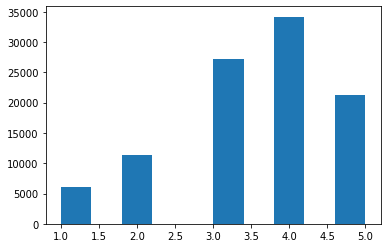

In [23]:
plt.figure()
plt.hist(data["rating"])
plt.show()

In [24]:
movies

,title,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
movie,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Mat' i syn (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1679,B. Monkey (1998),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1680,Sliding Doors (1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [27]:
train

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,166,346,1
4,298,474,4
...,...,...,...
89995,378,78,3
89996,880,476,3
89997,716,204,5
89998,276,1090,1


In [28]:
test

,user,movie,rating
0,707,766,3
1,943,188,4
2,772,313,5
3,828,26,3
4,854,514,4
...,...,...,...
9995,13,858,1
9996,7,79,4
9997,588,1058,2
9998,916,727,4


# Collaborative Filtering

The remainder of this notebook attempts to implement recommender systems as per the following link: https://cambridgespark.com/recommender-systems-in-python/

In [34]:
# Count the number of unique users and movies.

n_users = data.user.unique().shape[0]
n_items = data.movie.unique().shape[0]
print(n_users, n_items)

943 1682


In [39]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train.itertuples():
    train_data_matrix[line[1] - 1, line[2] - 1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [36]:
train_data_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [37]:
test_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Let's verify (with a single data point, so take that as you will) that we filled the matrices properly.
train_data_matrix[716 - 1][204 - 1]

5.0

In [46]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [47]:
user_similarity

array([[0.        , 0.85985785, 0.94928923, ..., 0.84635709, 0.85010599,
        0.64041858],
       [0.85985785, 0.        , 0.8815618 , ..., 0.83267152, 0.85724584,
        0.92123221],
       [0.94928923, 0.8815618 , 0.        , ..., 0.89536052, 0.88206987,
        0.9705163 ],
       ...,
       [0.84635709, 0.83267152, 0.89536052, ..., 0.        , 0.89250923,
        0.92131092],
       [0.85010599, 0.85724584, 0.88206987, ..., 0.89250923, 0.        ,
        0.84093585],
       [0.64041858, 0.92123221, 0.9705163 , ..., 0.92131092, 0.84093585,
        0.        ]])

In [48]:
item_similarity

array([[0.        , 0.62769459, 0.69674321, ..., 1.        , 0.95032876,
        0.95032876],
       [0.62769459, 0.        , 0.74470594, ..., 1.        , 0.91640827,
        0.91640827],
       [0.69674321, 0.74470594, 0.        , ..., 1.        , 1.        ,
        0.89781959],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.95032876, 0.91640827, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.95032876, 0.91640827, 0.89781959, ..., 1.        , 1.        ,
        0.        ]])

In [49]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)])
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [50]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

ValueError: operands could not be broadcast together with shapes (943,1682) (1,943) 

In [51]:
ratings = train_data_matrix
similarity = user_similarity
type = 'user'

if type == 'user':
    mean_user_rating = ratings.mean(axis=1)

    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)])
elif type == 'item':
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

ValueError: operands could not be broadcast together with shapes (943,1682) (1,943) 

In [53]:
mean_user_rating.shape

(943,)

In [54]:
similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)])

ValueError: operands could not be broadcast together with shapes (943,1682) (1,943) 

In [56]:
similarity.dot(ratings_diff).shape

(943, 1682)

In [57]:
np.array([np.abs(similarity).shape

SyntaxError: unexpected EOF while parsing (<ipython-input-57-92e787244f6f>, line 1)